<a href="https://colab.research.google.com/github/Quicknick123/DataFrames/blob/main/Kopie_von_crypto_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto asset index creation tutorial

## Synopsis:
In this notebook, an example index is created. Akin to the German DAX, a total return index is chosen. 
Functions for the basic ingredients to create an index are first defined and then applied in a loop to compute the daily value of the index.
These ingredients are 

1. an asset selection
2. a metric 
3. a weighting logic

The example given below uses the total market capitalization for the selection (1.) and the returns of the selected assets as a metric (2.). For the weighting logic (3.), three examples are given (the relative fraction of the asset's market capitalization, the rank of the asset's market capitalization, and the tangent hyperbolic of the relative fraction of the asset's market capitalization). 

## Suggestions for creating a custom index

- perform asset selection differently (by sector, by market segment, or even by taste )
- change the selected metric (e.g.: price or volatility instead of returns)
- define a different set of weighting logics

## Suggestions for additional visualizations
- visualize constituents contributions
- visualize relative performance of assets compared to created indices

## Questions to discuss
- what are reasonable ways to construct indices for the DeFi space?
    - how to select the assets? 
    - what (performance) metrics are best?
- what is the benefit of a return / price / volatility / other indices?
    - what quantitative measures can be applied to assess these benefits?

The data provided was acquired from Santiment and is for the purpose of this workshop and your private use only.

### import required modules 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### import the data and fill/delete all undefined/spurious values

In [16]:
cryptoDataURL = 'https://www.dropbox.com/s/uz5dnkwvca6hl9s/indexPricesAndCapsFrom2019.csv?dl=0'


In [17]:
!wget -O indexPricesAndCapsFrom2019.csv https://www.dropbox.com/s/uz5dnkwvca6hl9s/indexPricesAndCapsFrom2019.csv?dl=0

--2022-07-25 16:30:33--  https://www.dropbox.com/s/uz5dnkwvca6hl9s/indexPricesAndCapsFrom2019.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uz5dnkwvca6hl9s/indexPricesAndCapsFrom2019.csv [following]
--2022-07-25 16:30:33--  https://www.dropbox.com/s/raw/uz5dnkwvca6hl9s/indexPricesAndCapsFrom2019.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04e853d68763beb94916c90088.dl.dropboxusercontent.com/cd/0/inline/BpysqJVmnr8kem_n4OU7EMHXsD8_56fRV2QfgOLx9iOgFxL2QX4HI201n94pO0u4pyEuKoWBsH7utkWLhF7iV2_PjTLWC5bDNBBACz9gSTvAgNZe1EhCVJ6sbWOgaA8vN8Pwlzz23pvOlc7VP-R1BfBOWrymJHChYxMmatUWSPUK-Q/file# [following]
--2022-07-25 16:30:33--  https://uc04e853d68763beb94916c90088.dl.dropboxusercontent.com/cd/0/inline/BpysqJVmn

In [146]:
caps_and_prices_df = pd.read_csv('indexPricesAndCapsFrom2019.csv')


In [19]:
caps_and_prices_df.columns

Index(['datetime', 'inmax_price', 'dex_price', 'b2bx_price', 'kun_price',
       'bibox-token_price', 'dew_price', 'internationalcryptox_price',
       'themis_price', 'mothership_price',
       ...
       'labh-coin_cap', 'gincoin_cap', 'opcoinx_cap', 'blocknode_cap',
       'bitblocks_cap', 'lightpaycoin_cap', 'electra_cap', 'bitcoin-token_cap',
       'newyorkcoin_cap', 'ergo_cap'],
      dtype='object', length=364)

In [21]:
max(pd.to_datetime(caps_and_prices_df.datetime)) - min(pd.to_datetime(caps_and_prices_df.datetime))

Timedelta('1301 days 00:00:00')

In [22]:
caps_and_prices_df.head()

,datetime,inmax_price,dex_price,b2bx_price,kun_price,bibox-token_price,dew_price,internationalcryptox_price,themis_price,mothership_price,...,labh-coin_cap,gincoin_cap,opcoinx_cap,blocknode_cap,bitblocks_cap,lightpaycoin_cap,electra_cap,bitcoin-token_cap,newyorkcoin_cap,ergo_cap
0,2019-01-01 00:00:00+00:00,NaN,0.308100,0.244014,6.127182,0.144686,0.075974,0.001859,0.001781,0.034137,...,NaN,5804029.0,62830.0,148950.0,54542.0,1757365.0,7019092.0,246158.0,1535215.0,754228.0
1,2019-01-02 00:00:00+00:00,NaN,0.309181,0.243702,5.958004,0.149687,0.067813,0.002326,0.001855,0.034154,...,NaN,5898573.0,64191.0,145397.0,61068.0,1807096.0,7857406.0,259670.0,1648943.0,865997.0
2,2019-01-03 00:00:00+00:00,NaN,0.298392,0.256375,6.036914,0.147745,0.052490,0.002307,0.001698,0.035097,...,NaN,5532470.0,65512.0,154490.0,63168.0,1796951.0,8468945.0,275621.0,1552008.0,762340.0
3,2019-01-04 00:00:00+00:00,NaN,0.298530,0.256308,5.998166,0.145511,0.055931,0.001733,0.001657,0.039844,...,NaN,5438644.0,62900.0,141200.0,54498.0,1778597.0,7587031.0,249792.0,1734412.0,846089.0
4,2019-01-05 00:00:00+00:00,NaN,0.155830,0.259974,6.175592,0.147712,0.080857,0.001453,0.001568,0.042679,...,NaN,5377949.0,62559.0,146397.0,58380.0,1800910.0,7916481.0,275273.0,2010402.0,825260.0


In [147]:
caps_and_prices_df=caps_and_prices_df.ffill().bfill()

listToDrop=['business-credit-alliance-chain_price','business-credit-alliance-chain_cap','centercoin_price','chex_price', 'mex_price', 'otcbtc-token_price', 'capdaxtoken_price', 'key_price', 'valuechain_price', 'digifinextoken_price', 'valuto_price', 'dascoin_price', 'futurocoin_price'] 

caps_and_prices_df.drop(columns=listToDrop,inplace=True, axis = 1)

In [148]:
tokens = list(set(map(lambda x: x.split("_")[0], list(caps_and_prices_df.columns))))


In [142]:
tokens

['dimecoin',
 'hashcoin',
 'clearpoll',
 'shard',
 'xdna',
 'absolute',
 'soarcoin',
 'flo',
 'opcoinx',
 'electra',
 'abbc-coin',
 'metronome',
 'lightpaycoin',
 'bitcoin-cash',
 'digitalnote',
 'aurora',
 'kalkulus',
 'linda',
 'stellar',
 'blocktrade-token',
 'ubiq',
 'litecoin-cash',
 'emercoin',
 'benz',
 'agrello-delta',
 'block-array',
 'bitcoin',
 'blocknode',
 'steem',
 'labh-coin',
 'bitcoin-atom',
 'newyorkcoin',
 'ether-zero',
 'dex',
 'ormeus-coin',
 'b2bx',
 'w3coin',
 'zap',
 'pitiscoin',
 'hurify',
 'binance-coin',
 'ilcoin',
 'dogecoin',
 'covesting',
 'global-currency-reserve',
 'telcoin',
 'suqa',
 'feathercoin',
 'parallelcoin',
 'bitcoin-one',
 'bibox-token',
 'apr-coin',
 'tomochain',
 'cardano',
 'ethereum',
 'wixlar',
 'ruff',
 'ethereum-classic',
 'mir-coin',
 'boolberry',
 'faircoin',
 'peercoin',
 'adbank',
 'shekel',
 '0xbtc',
 'unobtanium',
 'bitcoin-sv',
 'fantom',
 'bitblocks',
 'stk',
 'davinci-coin',
 'bitcoinote',
 'niobium-coin',
 'raiden-network-toke

In [149]:
tokens.remove("datetime")

In [138]:
tokens.index("binance-coin")

40

In [100]:
local_df = caps_and_prices_df.copy()


### --> Here would be a good place to experiment with asset selection.

In [150]:
# ATTENTION: this is untested :) 
mySelection = ['leocoin', "huobi-token", "binance-coin", "opcoinx", "kucoin-shares"]
for token in tokens:
    token_columns = ["".join([token, x]) for x in ["_price", "_cap"]]
    if token not in mySelection:
      caps_and_prices_df.drop(columns=token_columns, inplace = True)

In [151]:
caps_and_prices_df.head()

,datetime,huobi-token_price,kucoin-shares_price,binance-coin_price,leocoin_price,opcoinx_price,huobi-token_cap,kucoin-shares_cap,binance-coin_cap,leocoin_cap,opcoinx_cap
0,2019-01-01 00:00:00+00:00,1.109692,0.640510,6.075273,0.059132,0.000809,55484820.0,57734363.0,794641453.0,6016238.0,62830.0
1,2019-01-02 00:00:00+00:00,1.156190,0.653204,6.188613,0.059728,0.000827,57809725.0,58878609.0,809466353.0,6076945.0,64191.0
2,2019-01-03 00:00:00+00:00,1.090098,0.614014,5.901921,0.057593,0.000844,54505127.0,55346123.0,771967119.0,5859707.0,65512.0
3,2019-01-04 00:00:00+00:00,1.093280,0.605391,6.065138,0.052544,0.000810,54664240.0,54568823.0,793315819.0,5345966.0,62900.0
4,2019-01-05 00:00:00+00:00,1.094235,0.606198,6.065543,0.058834,0.000806,54711985.0,54641528.0,793368779.0,5985921.0,62559.0


### the price columns have the suffix '_price' and the market capitalization columns have the suffix '_cap'

In [169]:
caps_and_prices_df.describe()

,huobi-token_price,kucoin-shares_price,binance-coin_price,leocoin_price,opcoinx_price,huobi-token_cap,kucoin-shares_cap,binance-coin_cap,leocoin_cap,opcoinx_cap,...,binance-coin_returns_1,leocoin_returns_1,opcoinx_returns_1,totalIndexCap,marketCapWeightedReturns,marketCapRankWeightedReturns,marketTanhWeightedReturns,linearWeightingIndex,rankWeightingIndex,tanhWeightingIndex
count,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1.302000e+03,1.302000e+03,1.302000e+03,1.302000e+03,1302.000000,...,1302.000000,1302.000000,1302.000000,1.302000e+03,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000
mean,6.838365,6.315389,173.923376,0.077447,0.000382,1.180014e+09,5.278473e+08,2.810829e+10,1.801273e+06,54484.620584,...,0.004395,0.093374,0.020892,2.981800e+10,0.004283,0.004305,0.004049,28523.791314,28585.597821,25076.874000
std,5.073178,7.305497,197.959365,0.046696,0.000486,9.243646e+08,6.088058e+08,3.247111e+10,2.774084e+06,68875.330701,...,0.055768,3.208470,0.248671,3.366008e+10,0.053777,0.054163,0.051268,32169.468177,32281.158561,27573.428171
min,0.918539,0.348388,5.568757,0.000581,0.000084,4.592713e+07,3.133397e+07,7.283895e+08,1.766000e+03,13642.000000,...,-0.423842,-0.558625,-0.756056,8.324903e+08,-0.404022,-0.409149,-0.378541,912.647493,914.076649,902.158464
25%,3.694672,0.968786,18.239553,0.046425,0.000130,7.413826e+08,7.939373e+07,2.768618e+09,4.905218e+05,21274.000000,...,-0.020224,-0.019926,0.000000,3.657041e+09,-0.018904,-0.018885,-0.017427,3255.935527,3191.802229,3558.916137
50%,4.661739,1.409038,30.681977,0.085046,0.000130,9.603725e+08,1.217367e+08,4.478079e+09,5.749680e+05,21274.000000,...,0.001498,0.000000,0.000000,5.122484e+09,0.002297,0.002003,0.002483,5172.508732,5163.393331,4983.931677
75%,9.413480,11.306608,355.228911,0.107072,0.000353,1.483920e+09,9.581111e+08,5.682696e+10,1.136416e+06,56670.750000,...,0.028554,0.015392,0.000000,6.003472e+10,0.027146,0.027086,0.025300,57971.703317,58154.123793,49739.496866
max,34.649789,27.565544,675.684077,0.377297,0.005237,6.212219e+09,2.208514e+09,1.091405e+11,1.318822e+07,823612.000000,...,0.697604,115.661526,2.941767,1.127463e+11,0.689169,0.691023,0.671588,109645.227689,110207.602091,94317.758555


### definition of routine to obtain and add the total and the relative market capitalization
### -> this will create columns with the suffix '_relCap' and one 'totalMarketCap' column

In [108]:
def getTotalAndRelativeMarketCap(capCols:list=None,marketData:pd.DataFrame=None):
    marketData['totalMarketCap'] = marketData[capCols].sum(axis=1)
    for capCol in capCols:
        relCapCol = capCol.replace('_cap','_relCap')
        marketData[relCapCol] = marketData[capCol]/marketData['totalMarketCap']
    return marketData

In [152]:
capCols = [col for col in caps_and_prices_df.columns if '_cap' in col]
caps_and_prices_df = getTotalAndRelativeMarketCap(capCols=capCols, marketData=caps_and_prices_df)

In [153]:
for cap in capCols:
    values = caps_and_prices_df[[cap]].iloc[880:884]
    max = float(np.amax(values))
    min = float(np.amin(values))

    if max/min > 100:
        print(f"what? {cap}: {min} {max} {values}")

### collecting columns of prices and (relative) market caps in lists 

In [154]:
priceCols = [col for col in caps_and_prices_df.columns if '_price' in col]
relCapCols =  [col for col in caps_and_prices_df.columns if '_relCap' in col]

In [155]:
len(priceCols)

5

In [156]:
len(relCapCols)

5

## routine to rank the assets according to their relative market capitalization
### --> here would be a good place to play with performance metrics

In [157]:
def getRelCapRanks(coins:list=None, values:np.ndarray = None):
    temp = values.argsort()
    ranks = np.arange(len(values))[temp.argsort()]

    ranksDict = {}
    for coin,rank in zip(coins,ranks):
        ranksDict[coin] = len(ranks)-rank
    return ranksDict

## routine to compute returns with a window of 'lag'
### --> here would be a good place to play with performance metrics

In [158]:
def addReturns(priceCols:list,lag:int=1, marketData:pd.DataFrame=None):
    for priceCol in priceCols:
        returnsCol = priceCol.replace('_price',f'_returns_{lag}')
        marketData[returnsCol] = marketData[priceCol].pct_change(lag).fillna(0.0)
    return marketData


In [159]:
caps_and_prices_df = addReturns(priceCols=priceCols, marketData=caps_and_prices_df)

### playground for weighting function (here, tangent hyperbolic)

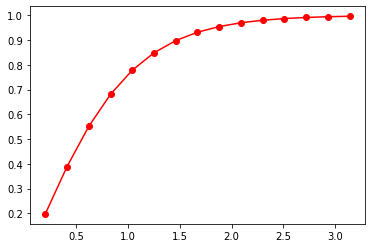

In [117]:
plt.plot(
    np.linspace(0.2, np.pi, 15),  # values on horizontal axis (rank of constituents)
    np.tanh(np.linspace(0.2, np.pi, 15)),  # values on vertical axis (weights)
    color = 'red', marker = "o" # markers 
    )

## Routine for computing weights and denominator of index at a single point in time
### --> here would be a good place to play with weighting logics

In [118]:
def getWeightsAndDenominator(
    weighting:str ='linear', 
    capRankDict: dict = None, 
    numConstituents:int = None,
    marketData:pd.DataFrame = None,
    constituentsCapsCols: list = None,
    tanhOffset: float = 0.2,
    timeIndex: int = None,
    totalIndexCap: float = None,
    ):    
    
    if weighting == 'rank' or weighting == 'tanh':
        maxRank = -1 
        rankSum = 1
        for j in capRankDict.values():
            if j <= numConstituents:
                rankSum+=j
                if j>maxRank:
                    maxRank=j
        if rankSum == 0:
            rankSum = 1


    if weighting == 'rank':
        denominator = 0.0
        weights = np.linspace(1,numConstituents,numConstituents)
        weights = maxRank + 1 - weights
        for capCol in constituentsCapsCols:
            denominator += weights[capRankDict[capCol.replace('_cap','_relCap')]-1]*marketData[capCol].iloc[timeIndex]

    elif weighting == 'tanh':
        weights = np.tanh(np.linspace(tanhOffset, np.pi, maxRank))
        denominator = 0.0
        for capCol in constituentsCapsCols:
            denominator += weights[capRankDict[capCol.replace('_cap','_relCap')]-1]*marketData[capCol].iloc[timeIndex]
    else:
        weights = np.ones(numConstituents)
        denominator = totalIndexCap
    
    return weights, denominator

## Routine for assembling total returns weighted by market caps
### --> here would be a good place to play with performance metrics

In [119]:
def marketCapWeightedReturns(
    numConstituents:int = 15, 
    returnsSuffix:str='_returns_1', 
    weighting:str='linear',
    tanhOffset:float = 0.2,
    marketData:pd.DataFrame = None, 
    totalIndexCapCol:str = 'totalIndexCap',
    marketCapWeightedReturnsCol:str= 'marketCapWeightedReturns'
    ):

    # list of columns with returns and relative market caps
    returnsCols = [ col for col in list(marketData.columns) if returnsSuffix in col ]
    relCapCols = [ col.replace(returnsSuffix,'_relCap') for col in returnsCols ]

    # initializing lists for weightedReturns and total index cap
    totalIndexCap = []
    weightedReturns = []

    # loop through all data/time points 
    for i in range(len(marketData)):

        # ranking constituents via market capitalization
        capRankDict = getRelCapRanks(coins=relCapCols, values=caps_and_prices_df[relCapCols].iloc[i])

        # collect the returns of the constituents with the largest market capitalizations 
        constituentsReturnsCols = [ 
            constituent.replace('_relCap',returnsSuffix) for constituent in capRankDict.keys() if capRankDict[constituent]<=numConstituents
            ]
        # collect the column names of the constituents caps    
        constituentsCapsCols = [ col.replace(returnsSuffix,'_cap') for col in constituentsReturnsCols]
        # compute the total Index capitalization
        totalIndexCap.append(marketData[constituentsCapsCols].iloc[i].sum())

        # compute weighting parameters (weights and denominator)
        weights,denominator = getWeightsAndDenominator(
            weighting=weighting,
            capRankDict=capRankDict,
            numConstituents=numConstituents,
            marketData=marketData,
            constituentsCapsCols=constituentsCapsCols,
            tanhOffset=tanhOffset,
            timeIndex=i,
            totalIndexCap=totalIndexCap[-1],
        )

        # compute index total weighted returns value
        thisWeightedReturns = 0.0
        for capCol,returnsCol in zip(constituentsCapsCols,constituentsReturnsCols):
            if weighting == 'linear':
                thisWeightedReturns += marketData[capCol].iloc[i] * marketData[returnsCol].iloc[i] / denominator


            if weighting=='rank':
                thisWeightedReturns += marketData[returnsCol].iloc[i]\
                                        * marketData[capCol].iloc[i]\
                                        * weights[capRankDict[capCol.replace('_cap','_relCap')]-1] / denominator

            if weighting == 'tanh':

                thisWeightedReturns += marketData[returnsCol].iloc[i]\
                                        * marketData[capCol].iloc[i]\
                                        * weights[capRankDict[capCol.replace('_cap','_relCap')]-1] / denominator

        # grow a list of all weighted total returns
        weightedReturns.append(thisWeightedReturns)
    
    # update market data dataframe with total weighted returns and index capitalization 
    marketData[totalIndexCapCol] = pd.Series(totalIndexCap)
    marketData[marketCapWeightedReturnsCol] = pd.Series(weightedReturns)

    return marketData

### assembling the total returns columns for different types of weighting logics 

In [160]:
returnsIndexDf = marketCapWeightedReturns(marketData=caps_and_prices_df)

In [161]:
returnsIndexDf = marketCapWeightedReturns(
        marketData=caps_and_prices_df,
        weighting='rank',
        marketCapWeightedReturnsCol= 'marketCapRankWeightedReturns'
    )

In [162]:
returnsIndexDf = marketCapWeightedReturns(
        marketData=caps_and_prices_df,
        weighting='tanh',
        marketCapWeightedReturnsCol= 'marketTanhWeightedReturns'
    )

## index computation from total returns column (starting value times the cumulative product of total returns)

In [163]:
def generateIndexFromReturns(startingValue:float=1.0,returnsCol:pd.Series=None):
    return returnsCol.apply(lambda x:x+1).cumprod().multiply(startingValue)

In [164]:
returnsIndexDf['linearWeightingIndex'] = generateIndexFromReturns( startingValue=1000, returnsCol=returnsIndexDf.marketCapWeightedReturns)
returnsIndexDf['rankWeightingIndex'] = generateIndexFromReturns( startingValue=1000, returnsCol=returnsIndexDf.marketCapRankWeightedReturns)
returnsIndexDf['tanhWeightingIndex'] = generateIndexFromReturns( startingValue=1000, returnsCol=returnsIndexDf.marketTanhWeightedReturns)

In [165]:
returnsIndexDf.set_index('datetime',inplace=True)

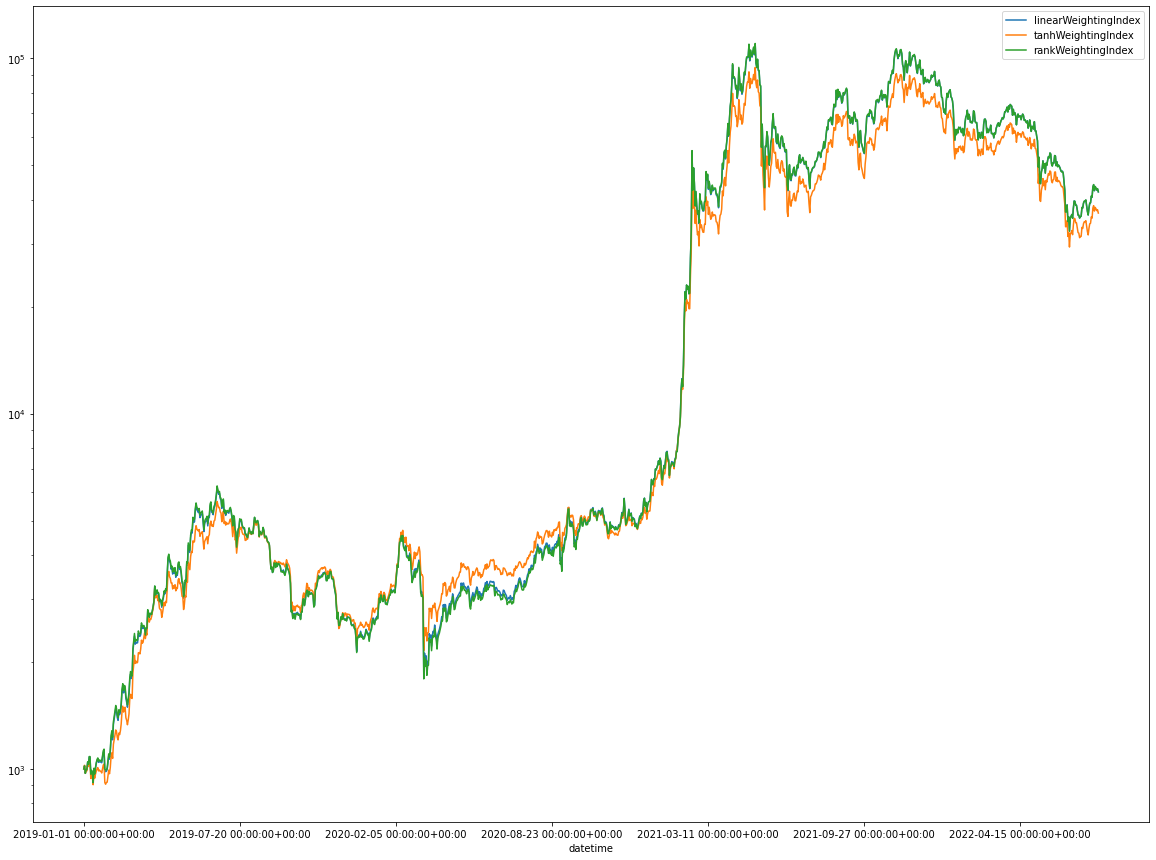

In [168]:
returnsIndexDf[['linearWeightingIndex','tanhWeightingIndex','rankWeightingIndex']].plot(logy=True,figsize=(20,15))

## some visualizations: comparison of index capitalization to bitcoin

In [167]:
returnsIndexDf[['totalIndexCap','bitcoin_cap']].plot(logy=True,figsize=(20,15))

KeyError: ignored